1. Importing Libraries

In [2]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

2. Data preperation

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Convert to NumPy
train_images = trainset.data.numpy()
train_labels = trainset.targets.numpy()

train_indices, val_indices = train_test_split(np.arange(len(train_images)), test_size=10000, stratify=train_labels, random_state=42)

train_subset = Subset(trainset, train_indices)
val_subset = Subset(trainset, val_indices)

print(f"Number of training samples: {len(train_subset)}")
print(f"Number of validation samples: {len(val_subset)}")
print(f"Number of test samples: {len(testset)}")

trainloader = DataLoader(train_subset, batch_size=64, shuffle=True)
valloader = DataLoader(val_subset, batch_size=64, shuffle=False)
testloader = DataLoader(testset, batch_size=64, shuffle=False)

Number of training samples: 50000
Number of validation samples: 10000
Number of test samples: 10000


3. Defining the Neural Network

In [ ]:
class DynamicNN(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers):

        super(DynamicNN, self).__init__()
        layers = []

        # Input layer
        layers.append(nn.Linear(input_size, hidden_layers[0]))
        layers.append(nn.ReLU())

        # Hidden layers
        for i in range(1, len(hidden_layers)):
            layers.append(nn.Linear(hidden_layers[i - 1], hidden_layers[i]))
            layers.append(nn.ReLU())

        # Output layer
        layers.append(nn.Linear(hidden_layers[-1], output_size))

        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, 784)
        return self.model(x)

4. setting up training and validation process

In [ ]:
def train_and_validate(model, trainloader, valloader, criterion, optimizer, num_epochs):

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_train_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in trainloader:
            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_train_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            correct_train += (predicted == labels).sum().item()
            total_train += labels.size(0)

        avg_train_loss = running_train_loss / len(trainloader)
        train_accuracy = correct_train / total_train
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)

        # Validation phase
        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        with torch.no_grad():
            for inputs, labels in valloader:
                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_val_loss += loss.item()

                _, predicted = torch.max(outputs, 1)
                correct_val += (predicted == labels).sum().item()
                total_val += labels.size(0)

        avg_val_loss = running_val_loss / len(valloader)
        val_accuracy = correct_val / total_val
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)

        print(f"Epoch {epoch + 1}/{num_epochs}:")
        print(f"  Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")
        print(f"  Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")

    return {
        "train_losses": train_losses,
        "val_losses": val_losses,
        "train_accuracies": train_accuracies,
        "val_accuracies": val_accuracies,
    }

#===============================================================================>

def plot_metrics(metrics, title_suffix=""):
    plt.figure(figsize=(12, 5))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(metrics["train_losses"], label="Training Loss")
    plt.plot(metrics["val_losses"], label="Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Training vs. Validation Loss {title_suffix}")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(metrics["train_accuracies"], label="Training Accuracy")
    plt.plot(metrics["val_accuracies"], label="Validation Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title(f"Training vs. Validation Accuracy {title_suffix}")
    plt.legend()

    plt.tight_layout()
    plt.show()

5. Training the model

Epoch 1/5:
  Training Loss: 1.1661, Training Accuracy: 0.6910
  Validation Loss: 0.5090, Validation Accuracy: 0.8569
Epoch 2/5:
  Training Loss: 0.4051, Training Accuracy: 0.8853
  Validation Loss: 0.3686, Validation Accuracy: 0.8922
Epoch 3/5:
  Training Loss: 0.3353, Training Accuracy: 0.9021
  Validation Loss: 0.3220, Validation Accuracy: 0.9061
Epoch 4/5:
  Training Loss: 0.3030, Training Accuracy: 0.9114
  Validation Loss: 0.2969, Validation Accuracy: 0.9115
Epoch 5/5:
  Training Loss: 0.2790, Training Accuracy: 0.9186
  Validation Loss: 0.2771, Validation Accuracy: 0.9191


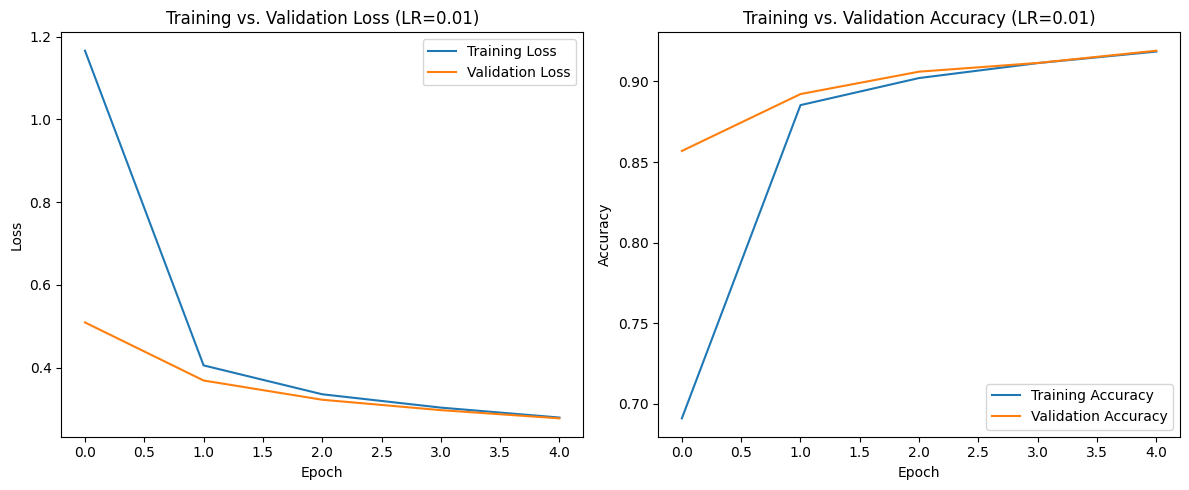

In [6]:
model = DynamicNN(input_size=784, output_size=10, hidden_layers=[128, 64])
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
criterion = nn.CrossEntropyLoss()
metrics = train_and_validate(model, trainloader, valloader, criterion, optimizer, num_epochs=5)
plot_metrics(metrics, title_suffix=f"(LR={0.01})")

6. Analysis: Changing Learning Rates

Training with learning rate: 0.001
Epoch 1/5:
  Training Loss: 2.2462, Training Accuracy: 0.2581
  Validation Loss: 2.1870, Validation Accuracy: 0.3789
Epoch 2/5:
  Training Loss: 2.0994, Training Accuracy: 0.4748
  Validation Loss: 1.9878, Validation Accuracy: 0.5534
Epoch 3/5:
  Training Loss: 1.8259, Training Accuracy: 0.6023
  Validation Loss: 1.6399, Validation Accuracy: 0.6516
Epoch 4/5:
  Training Loss: 1.4407, Training Accuracy: 0.6934
  Validation Loss: 1.2491, Validation Accuracy: 0.7389
Epoch 5/5:
  Training Loss: 1.0941, Training Accuracy: 0.7637
  Validation Loss: 0.9609, Validation Accuracy: 0.7919


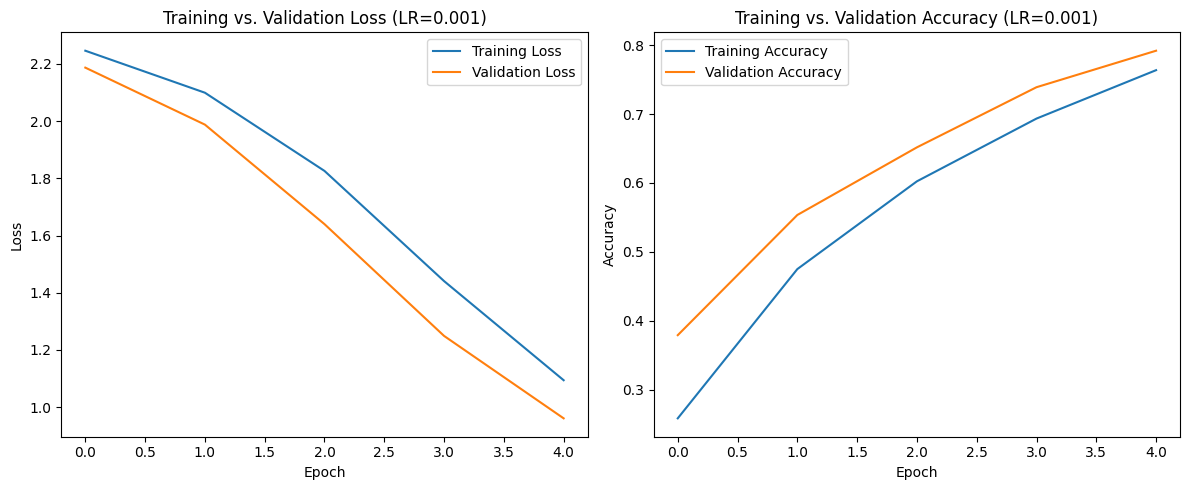

Training with learning rate: 0.01
Epoch 1/5:
  Training Loss: 1.1177, Training Accuracy: 0.6955
  Validation Loss: 0.4931, Validation Accuracy: 0.8611
Epoch 2/5:
  Training Loss: 0.4050, Training Accuracy: 0.8846
  Validation Loss: 0.3629, Validation Accuracy: 0.8976
Epoch 3/5:
  Training Loss: 0.3354, Training Accuracy: 0.9026
  Validation Loss: 0.3403, Validation Accuracy: 0.8995
Epoch 4/5:
  Training Loss: 0.3029, Training Accuracy: 0.9111
  Validation Loss: 0.2968, Validation Accuracy: 0.9153
Epoch 5/5:
  Training Loss: 0.2790, Training Accuracy: 0.9178
  Validation Loss: 0.2895, Validation Accuracy: 0.9142


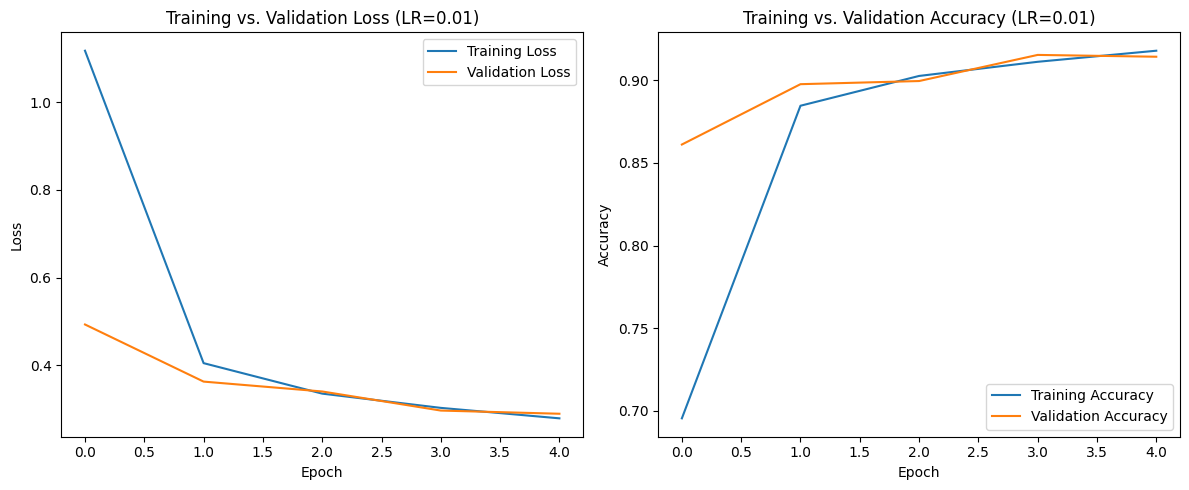

Training with learning rate: 0.1
Epoch 1/5:
  Training Loss: 0.4961, Training Accuracy: 0.8410
  Validation Loss: 0.3585, Validation Accuracy: 0.8624
Epoch 2/5:
  Training Loss: 0.1951, Training Accuracy: 0.9401
  Validation Loss: 0.5894, Validation Accuracy: 0.8252
Epoch 3/5:
  Training Loss: 0.1417, Training Accuracy: 0.9566
  Validation Loss: 0.1765, Validation Accuracy: 0.9463
Epoch 4/5:
  Training Loss: 0.1142, Training Accuracy: 0.9654
  Validation Loss: 0.3708, Validation Accuracy: 0.8913
Epoch 5/5:
  Training Loss: 0.0927, Training Accuracy: 0.9713
  Validation Loss: 0.1391, Validation Accuracy: 0.9589


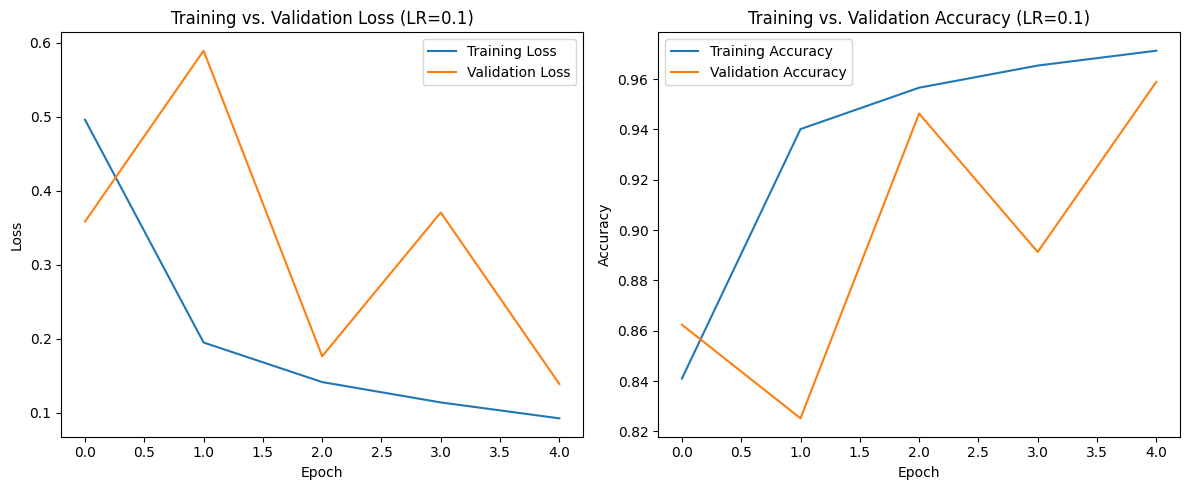

Training with learning rate: 0.5
Epoch 1/5:
  Training Loss: 2.3119, Training Accuracy: 0.1198
  Validation Loss: 2.3031, Validation Accuracy: 0.1124
Epoch 2/5:
  Training Loss: 2.3004, Training Accuracy: 0.1128
  Validation Loss: 2.3019, Validation Accuracy: 0.1124
Epoch 3/5:
  Training Loss: 2.3028, Training Accuracy: 0.1104
  Validation Loss: 2.3047, Validation Accuracy: 0.0987
Epoch 4/5:
  Training Loss: 2.3032, Training Accuracy: 0.1085
  Validation Loss: 2.3050, Validation Accuracy: 0.0993
Epoch 5/5:
  Training Loss: 2.3032, Training Accuracy: 0.1077
  Validation Loss: 2.3019, Validation Accuracy: 0.1124


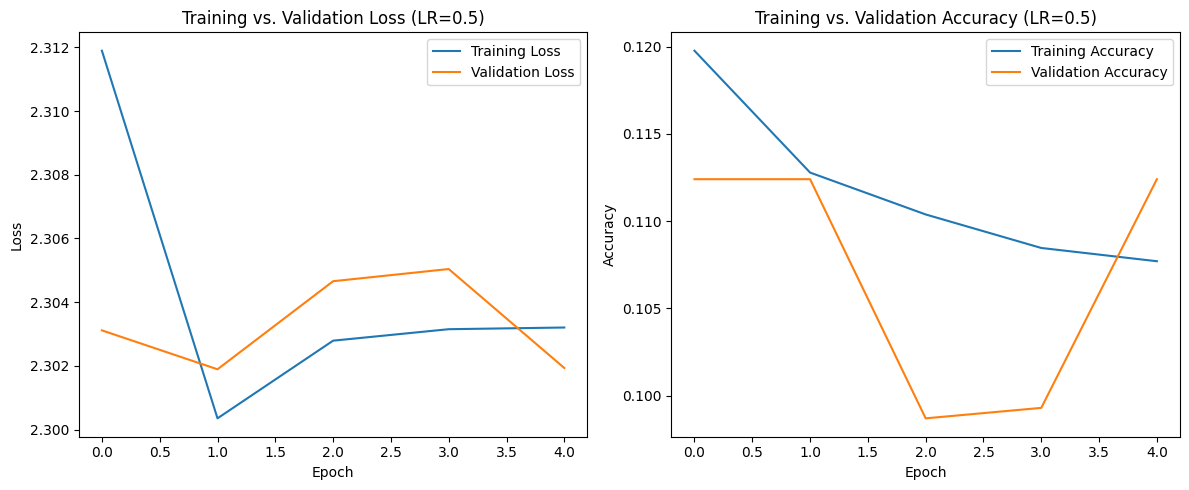

In [8]:
best_lr = None
best_batch_size = None
best_nn_config = None

highest_val_accuracy_lr = 0
highest_val_accuracy_batch = 0
highest_val_accuracy_nn = 0

# Different learning rates
learning_rates = [0.001, 0.01, 0.1,0.5]
for lr in learning_rates:
    print(f"Training with learning rate: {lr}")
    model = DynamicNN(input_size=784, output_size=10, hidden_layers=[128, 64])
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    metrics = train_and_validate(model, trainloader, valloader, criterion, optimizer, num_epochs=5)
    plot_metrics(metrics, title_suffix=f"(LR={lr})")

    final_val_accuracy = metrics["val_accuracies"][-1]
    if final_val_accuracy > highest_val_accuracy_lr:
        highest_val_accuracy_lr = final_val_accuracy
        best_lr = lr

7. Analysis: Changing Batch Sizes

Training with batch size: 16
Epoch 1/5:
  Training Loss: 0.6034, Training Accuracy: 0.8270
  Validation Loss: 0.3268, Validation Accuracy: 0.9054
Epoch 2/5:
  Training Loss: 0.2754, Training Accuracy: 0.9171
  Validation Loss: 0.2695, Validation Accuracy: 0.9232
Epoch 3/5:
  Training Loss: 0.2063, Training Accuracy: 0.9388
  Validation Loss: 0.1864, Validation Accuracy: 0.9470
Epoch 4/5:
  Training Loss: 0.1640, Training Accuracy: 0.9506
  Validation Loss: 0.1680, Validation Accuracy: 0.9508
Epoch 5/5:
  Training Loss: 0.1372, Training Accuracy: 0.9596
  Validation Loss: 0.1486, Validation Accuracy: 0.9577


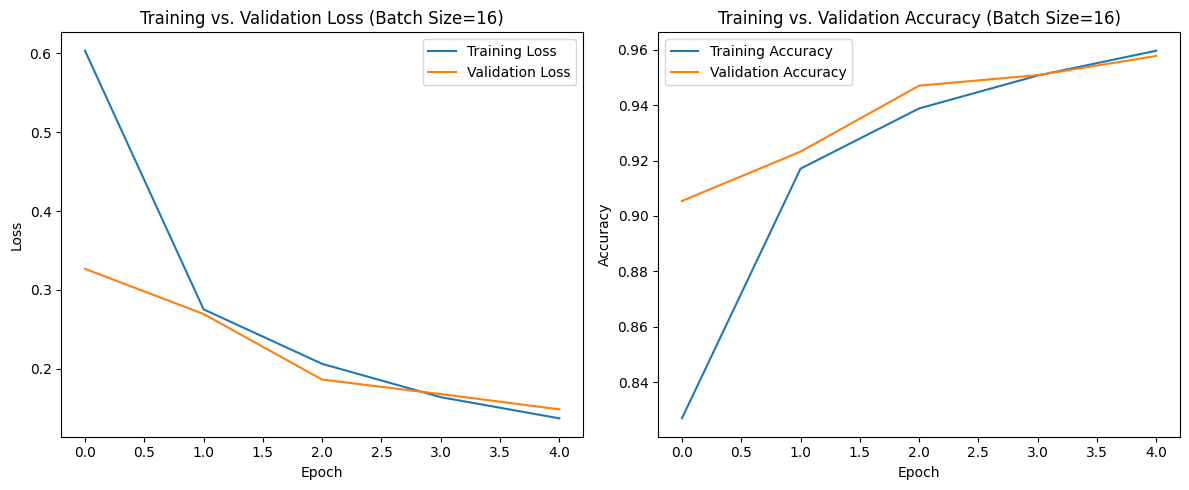

Training with batch size: 64
Epoch 1/5:
  Training Loss: 1.2161, Training Accuracy: 0.6771
  Validation Loss: 0.5289, Validation Accuracy: 0.8505
Epoch 2/5:
  Training Loss: 0.4175, Training Accuracy: 0.8820
  Validation Loss: 0.4002, Validation Accuracy: 0.8806
Epoch 3/5:
  Training Loss: 0.3447, Training Accuracy: 0.8982
  Validation Loss: 0.3318, Validation Accuracy: 0.9052
Epoch 4/5:
  Training Loss: 0.3112, Training Accuracy: 0.9080
  Validation Loss: 0.3183, Validation Accuracy: 0.9066
Epoch 5/5:
  Training Loss: 0.2886, Training Accuracy: 0.9137
  Validation Loss: 0.2988, Validation Accuracy: 0.9124


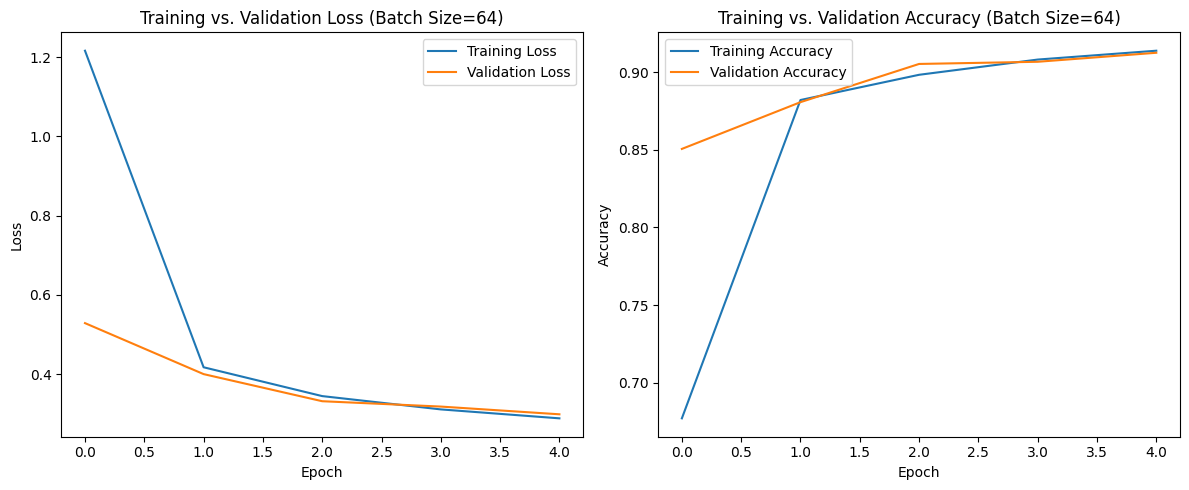

Training with batch size: 128
Epoch 1/5:
  Training Loss: 1.7069, Training Accuracy: 0.5309
  Validation Loss: 0.9330, Validation Accuracy: 0.7654
Epoch 2/5:
  Training Loss: 0.6535, Training Accuracy: 0.8281
  Validation Loss: 0.5038, Validation Accuracy: 0.8570
Epoch 3/5:
  Training Loss: 0.4502, Training Accuracy: 0.8727
  Validation Loss: 0.4148, Validation Accuracy: 0.8807
Epoch 4/5:
  Training Loss: 0.3883, Training Accuracy: 0.8893
  Validation Loss: 0.3814, Validation Accuracy: 0.8883
Epoch 5/5:
  Training Loss: 0.3563, Training Accuracy: 0.8969
  Validation Loss: 0.3515, Validation Accuracy: 0.8963


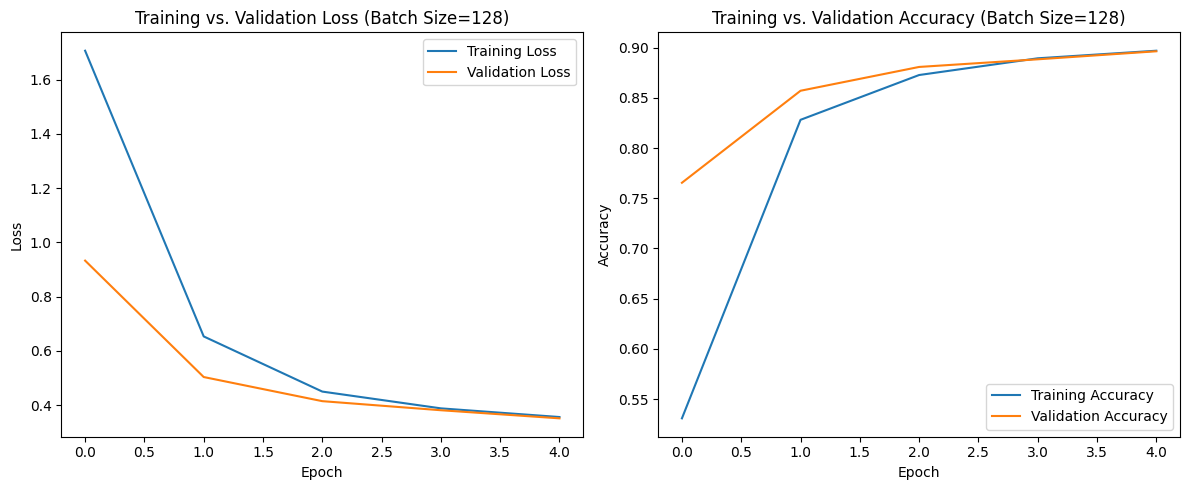

Training with batch size: 256
Epoch 1/5:
  Training Loss: 2.0850, Training Accuracy: 0.4548
  Validation Loss: 1.7355, Validation Accuracy: 0.6177
Epoch 2/5:
  Training Loss: 1.2748, Training Accuracy: 0.7152
  Validation Loss: 0.9140, Validation Accuracy: 0.7826
Epoch 3/5:
  Training Loss: 0.7393, Training Accuracy: 0.8140
  Validation Loss: 0.6155, Validation Accuracy: 0.8368
Epoch 4/5:
  Training Loss: 0.5481, Training Accuracy: 0.8524
  Validation Loss: 0.4997, Validation Accuracy: 0.8558
Epoch 5/5:
  Training Loss: 0.4624, Training Accuracy: 0.8712
  Validation Loss: 0.4431, Validation Accuracy: 0.8733


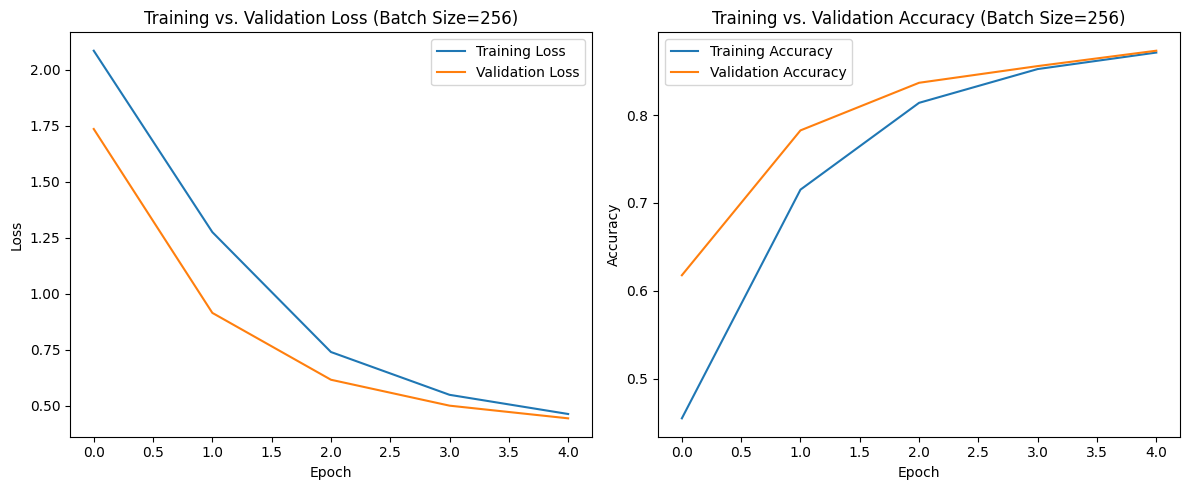

In [9]:
# Different batch sizes
batch_sizes = [16, 64, 128,256]
for batch_size in batch_sizes:
    print(f"Training with batch size: {batch_size}")
    trainloader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    valloader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    model = DynamicNN(input_size=784, output_size=10, hidden_layers=[128, 64])
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()
    metrics = train_and_validate(model, trainloader, valloader, criterion, optimizer, num_epochs=5)
    plot_metrics(metrics, title_suffix=f"(Batch Size={batch_size})")

    final_val_accuracy = metrics["val_accuracies"][-1]
    if final_val_accuracy > highest_val_accuracy_batch:
        highest_val_accuracy_batch = final_val_accuracy
        best_batch_size = batch_size


8. Analysis: Changing NN Configuration

Training with layer configuration: [64, 32]
Epoch 1/4:
  Training Loss: 1.2384, Training Accuracy: 0.6535
  Validation Loss: 0.5526, Validation Accuracy: 0.8470
Epoch 2/4:
  Training Loss: 0.4339, Training Accuracy: 0.8761
  Validation Loss: 0.4639, Validation Accuracy: 0.8564
Epoch 3/4:
  Training Loss: 0.3556, Training Accuracy: 0.8985
  Validation Loss: 0.3866, Validation Accuracy: 0.8903
Epoch 4/4:
  Training Loss: 0.3187, Training Accuracy: 0.9071
  Validation Loss: 0.3166, Validation Accuracy: 0.9076


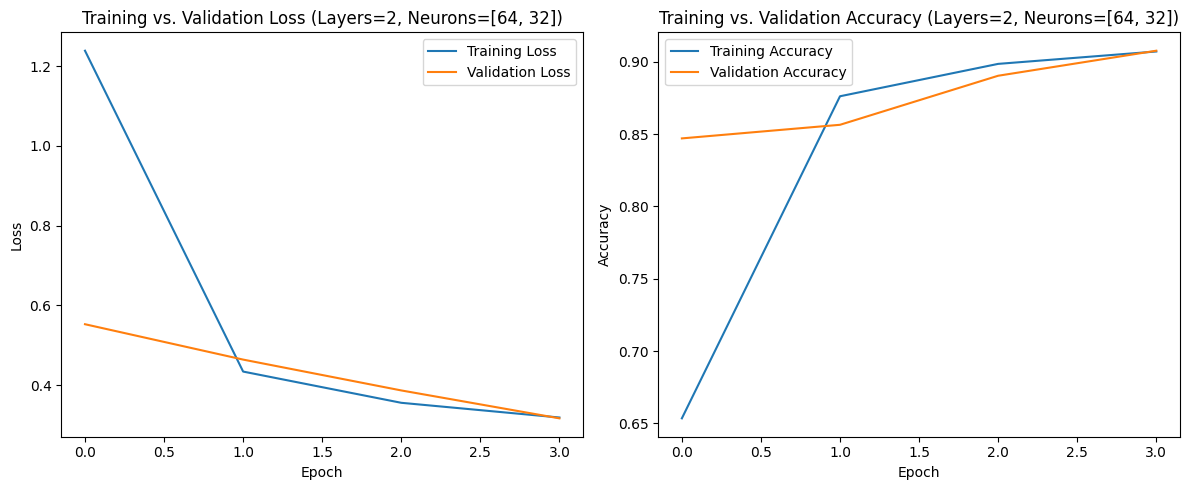

Training with layer configuration: [128, 64]
Epoch 1/4:
  Training Loss: 1.1164, Training Accuracy: 0.7073
  Validation Loss: 0.4947, Validation Accuracy: 0.8591
Epoch 2/4:
  Training Loss: 0.4075, Training Accuracy: 0.8836
  Validation Loss: 0.3653, Validation Accuracy: 0.8954
Epoch 3/4:
  Training Loss: 0.3431, Training Accuracy: 0.9000
  Validation Loss: 0.3488, Validation Accuracy: 0.8984
Epoch 4/4:
  Training Loss: 0.3110, Training Accuracy: 0.9098
  Validation Loss: 0.3328, Validation Accuracy: 0.8988


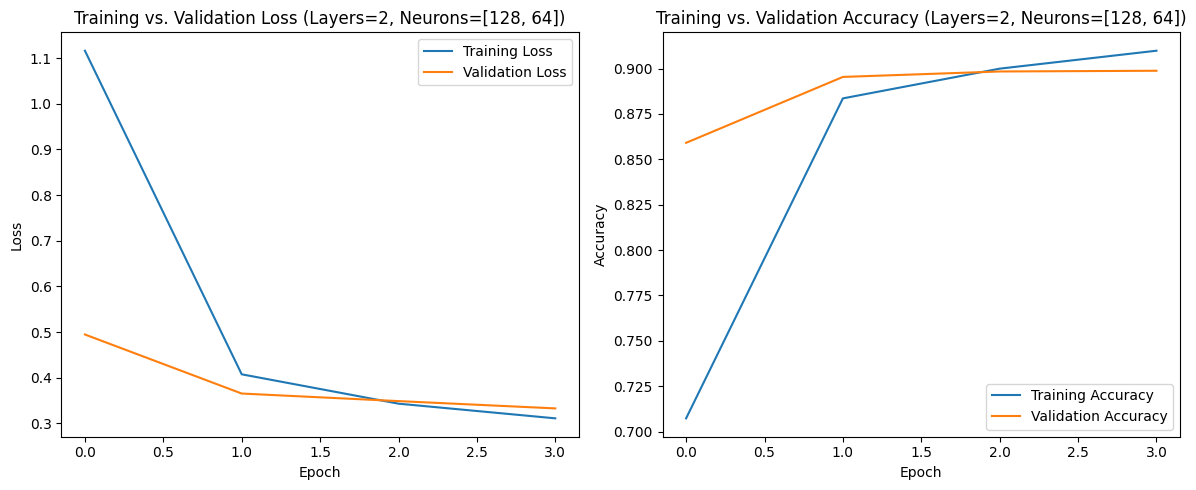

Training with layer configuration: [256, 128]
Epoch 1/4:
  Training Loss: 1.0830, Training Accuracy: 0.7346
  Validation Loss: 0.5106, Validation Accuracy: 0.8484
Epoch 2/4:
  Training Loss: 0.4029, Training Accuracy: 0.8848
  Validation Loss: 0.3910, Validation Accuracy: 0.8839
Epoch 3/4:
  Training Loss: 0.3374, Training Accuracy: 0.9020
  Validation Loss: 0.3583, Validation Accuracy: 0.8895
Epoch 4/4:
  Training Loss: 0.3038, Training Accuracy: 0.9111
  Validation Loss: 0.3114, Validation Accuracy: 0.9100


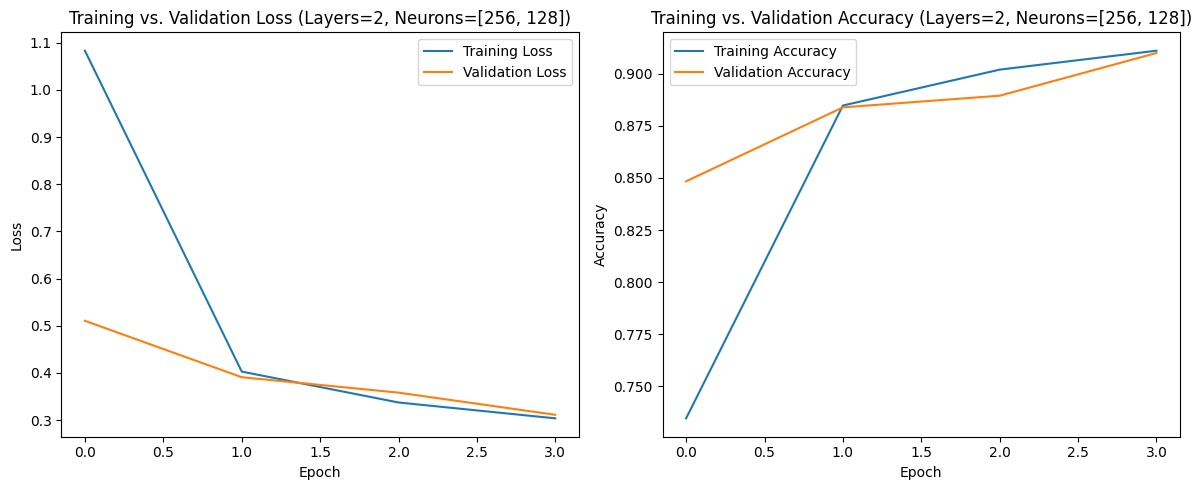

Training with layer configuration: [512, 256]
Epoch 1/4:
  Training Loss: 0.9909, Training Accuracy: 0.7612
  Validation Loss: 0.4892, Validation Accuracy: 0.8564
Epoch 2/4:
  Training Loss: 0.3878, Training Accuracy: 0.8887
  Validation Loss: 0.3577, Validation Accuracy: 0.8989
Epoch 3/4:
  Training Loss: 0.3275, Training Accuracy: 0.9042
  Validation Loss: 0.3216, Validation Accuracy: 0.9035
Epoch 4/4:
  Training Loss: 0.2960, Training Accuracy: 0.9133
  Validation Loss: 0.3078, Validation Accuracy: 0.9084


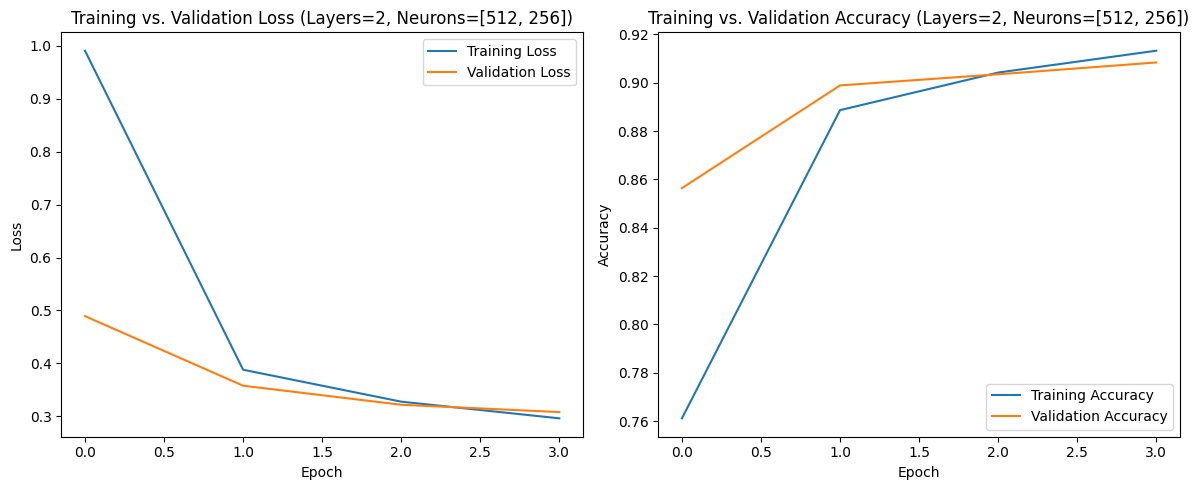

Training with layer configuration: [128, 64, 32]
Epoch 1/4:
  Training Loss: 1.6600, Training Accuracy: 0.4814
  Validation Loss: 0.8034, Validation Accuracy: 0.7562
Epoch 2/4:
  Training Loss: 0.5802, Training Accuracy: 0.8221
  Validation Loss: 0.4682, Validation Accuracy: 0.8560
Epoch 3/4:
  Training Loss: 0.4029, Training Accuracy: 0.8806
  Validation Loss: 0.3973, Validation Accuracy: 0.8849
Epoch 4/4:
  Training Loss: 0.3466, Training Accuracy: 0.8977
  Validation Loss: 0.3585, Validation Accuracy: 0.8978


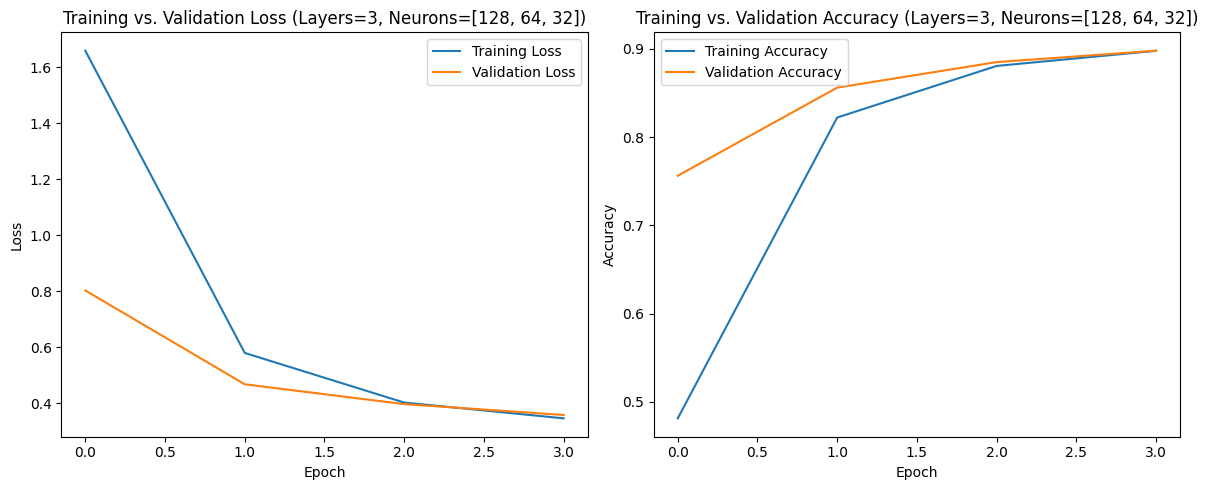

Training with layer configuration: [256, 128, 64]
Epoch 1/4:
  Training Loss: 1.5943, Training Accuracy: 0.5329
  Validation Loss: 0.7131, Validation Accuracy: 0.7989
Epoch 2/4:
  Training Loss: 0.4956, Training Accuracy: 0.8543
  Validation Loss: 0.4414, Validation Accuracy: 0.8657
Epoch 3/4:
  Training Loss: 0.3646, Training Accuracy: 0.8930
  Validation Loss: 0.3690, Validation Accuracy: 0.8911
Epoch 4/4:
  Training Loss: 0.3152, Training Accuracy: 0.9085
  Validation Loss: 0.3304, Validation Accuracy: 0.9008


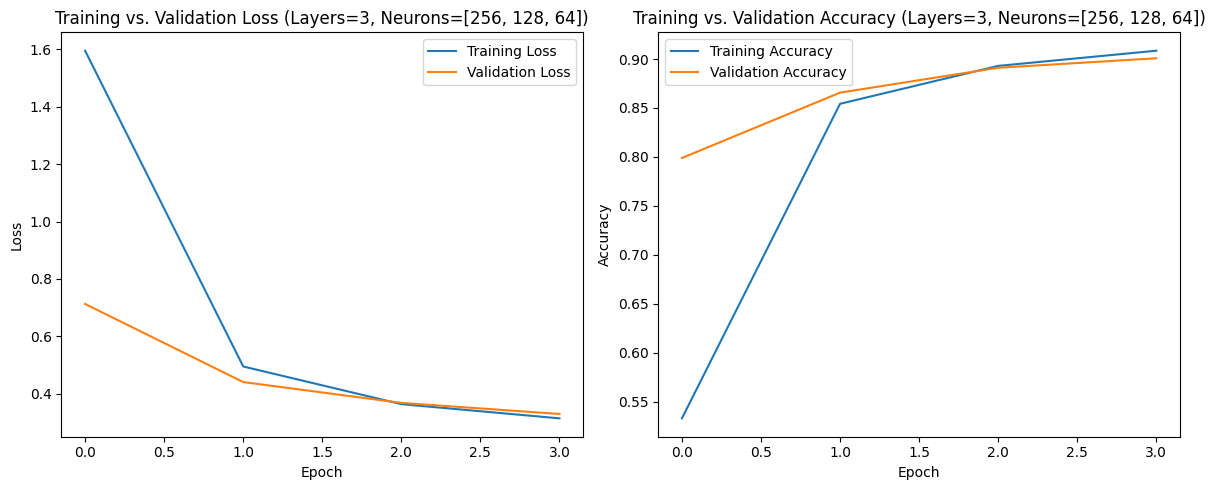

Training with layer configuration: [512, 256, 128]
Epoch 1/4:
  Training Loss: 1.5149, Training Accuracy: 0.5715
  Validation Loss: 0.6157, Validation Accuracy: 0.8172
Epoch 2/4:
  Training Loss: 0.4468, Training Accuracy: 0.8677
  Validation Loss: 0.4032, Validation Accuracy: 0.8784
Epoch 3/4:
  Training Loss: 0.3492, Training Accuracy: 0.8976
  Validation Loss: 0.3721, Validation Accuracy: 0.8877
Epoch 4/4:
  Training Loss: 0.3061, Training Accuracy: 0.9095
  Validation Loss: 0.3082, Validation Accuracy: 0.9121


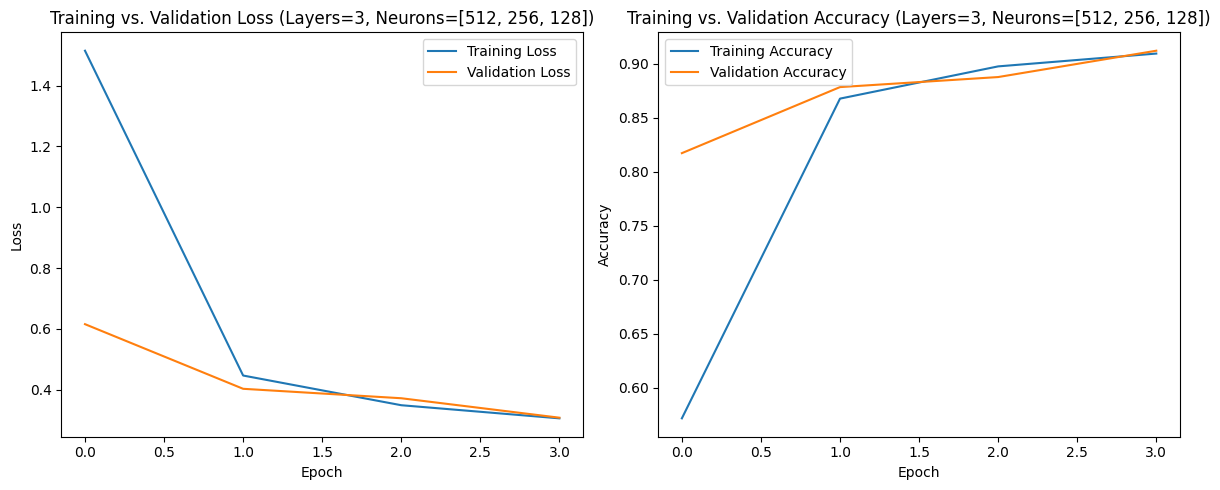

Training with layer configuration: [512, 256, 128, 64]
Epoch 1/4:
  Training Loss: 2.2153, Training Accuracy: 0.2335
  Validation Loss: 1.7955, Validation Accuracy: 0.3736
Epoch 2/4:
  Training Loss: 0.9097, Training Accuracy: 0.7087
  Validation Loss: 0.7471, Validation Accuracy: 0.7349
Epoch 3/4:
  Training Loss: 0.4580, Training Accuracy: 0.8620
  Validation Loss: 0.3957, Validation Accuracy: 0.8864
Epoch 4/4:
  Training Loss: 0.3594, Training Accuracy: 0.8945
  Validation Loss: 0.3834, Validation Accuracy: 0.8890


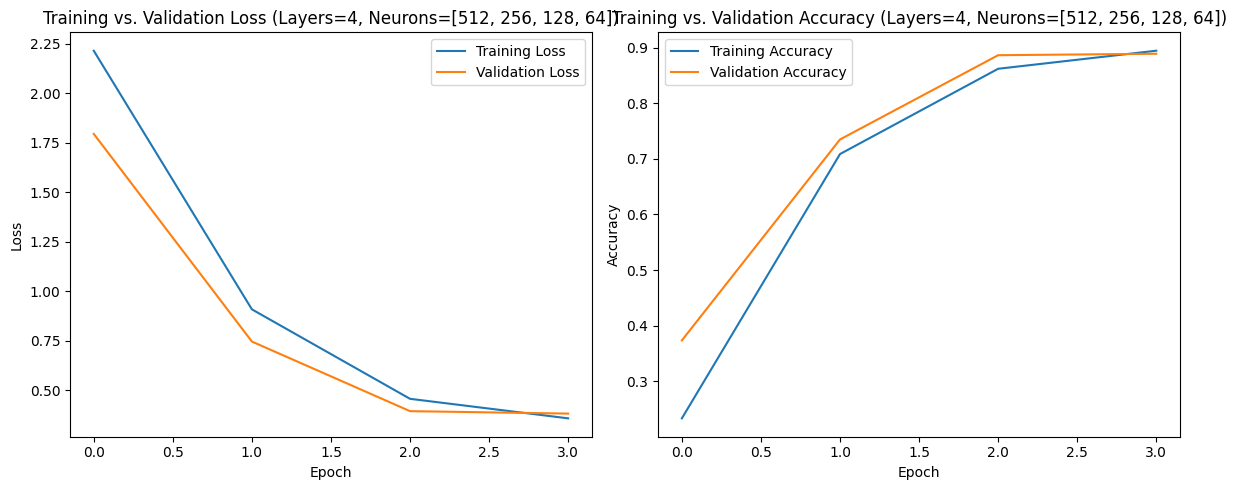

In [10]:
# Different nn configs
layer_neuron_configs = [
    [64, 32],
    [128, 64],
    [256, 128],
    [512, 256],
    [128, 64, 32],
    [256, 128, 64],
    [512, 256, 128],
    [512, 256, 128, 64],
]

for config in layer_neuron_configs:
    print(f"Training with layer configuration: {config}")
    model = DynamicNN(input_size=784, output_size=10, hidden_layers=config)
    trainloader = DataLoader(train_subset, batch_size=64, shuffle=True)
    valloader = DataLoader(val_subset, batch_size=64, shuffle=False)
    optimizer = torch.optim.SGD(model.parameters(), lr=0.01)
    criterion = nn.CrossEntropyLoss()
    metrics = train_and_validate(model, trainloader, valloader, criterion, optimizer, num_epochs=4)
    plot_metrics(metrics, title_suffix=f"(Layers={len(config)}, Neurons={config})")

    final_val_accuracy = metrics["val_accuracies"][-1]
    if final_val_accuracy > highest_val_accuracy_nn:
        highest_val_accuracy_nn = final_val_accuracy
        best_nn_config = config

9. Testing the Best Model

Epoch 1/5:
  Training Loss: 0.5509, Training Accuracy: 0.8212
  Validation Loss: 0.4238, Validation Accuracy: 0.8620
Epoch 2/5:
  Training Loss: 0.1845, Training Accuracy: 0.9427
  Validation Loss: 0.2675, Validation Accuracy: 0.9177
Epoch 3/5:
  Training Loss: 0.1295, Training Accuracy: 0.9585
  Validation Loss: 0.1371, Validation Accuracy: 0.9582
Epoch 4/5:
  Training Loss: 0.1094, Training Accuracy: 0.9664
  Validation Loss: 0.1069, Validation Accuracy: 0.9681
Epoch 5/5:
  Training Loss: 0.0799, Training Accuracy: 0.9754
  Validation Loss: 0.1700, Validation Accuracy: 0.9483


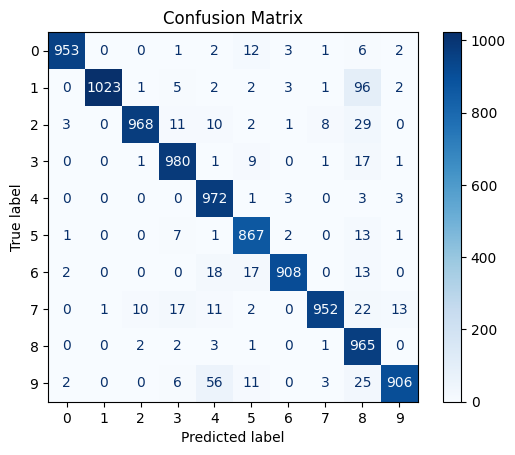

Test Accuracy: 0.9494


In [11]:
model = DynamicNN(input_size=784, output_size=10, hidden_layers=best_nn_config)
optimizer = torch.optim.SGD(model.parameters(), lr=best_lr)
criterion = nn.CrossEntropyLoss()
testloader = DataLoader(testset, batch_size=best_batch_size, shuffle=False)
train_and_validate(model, trainloader, valloader, criterion, optimizer, num_epochs=5)

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in testloader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.numpy())
        all_labels.extend(labels.numpy())

cm = confusion_matrix(all_labels, all_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[str(i) for i in range(10)])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

test_accuracy = np.mean(np.array(all_preds) == np.array(all_labels))
print(f"Test Accuracy: {test_accuracy:.4f}")
